First we load all the libraries that will be needed for the training and testing

In [ ]:
import pickle
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import math
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
import json
import pandas as pd
from PIL import ImageFilter, Image

The **CIFAR10Dataset** class loads and processes CIFAR-10 image data for use in deep learning models. It reads binary files, extracts images and labels, and reshapes them into 32x32 RGB format. The **_load_data** method stacks images into a NumPy array, while __len__ returns the dataset size. The **__getitem__** method retrieves an image and label, applies transformations if specified, and ensures the correct format for training. This class simplifies handling CIFAR-10 data in PyTorch.

In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data_files, transform=None):
        self.data, self.labels = self._load_data(data_files)
        self.transform = transform

    def _load_data(self, files):
        data, labels = [], []
        for file in files:
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                data.append(batch[b'data'])
                labels.extend(batch[b'labels'])
        data = np.vstack(data).reshape(-1, 3, 32, 32).astype(np.uint8)
        print(f"Loaded data shape: {data.shape}")
        return data, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        img = np.transpose(img, (1, 2, 0))
        if self.transform:
            img = self.transform(img)
        return img, label

Let us have a look at the images present in the dataset

In [ ]:
basic_transform = transforms.Compose([
    transforms.ToTensor()
])

data_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
dataset = CIFAR10Dataset(data_files, transform=basic_transform)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
random_indices = np.random.choice(len(dataset), 10, replace=False)

for i, idx in enumerate(random_indices):
    img, label = dataset[idx]
    img = img.numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].set_title(f"{classes[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Sample Images from CIFAR-10", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

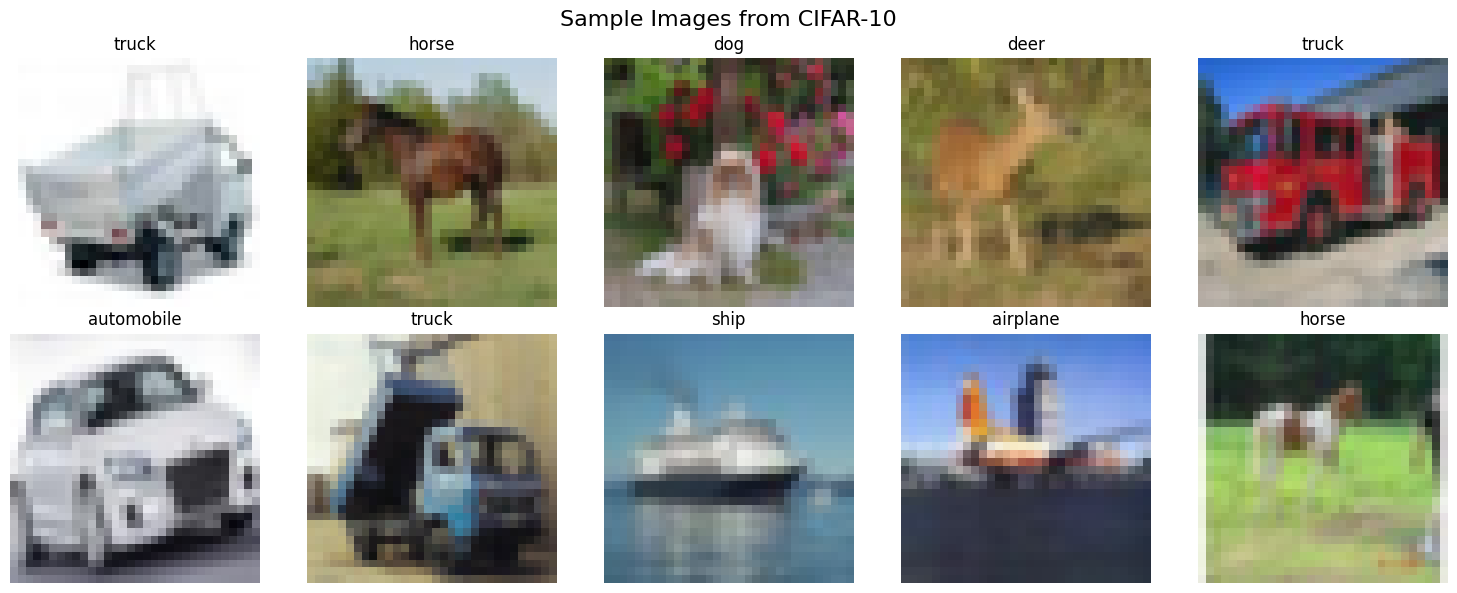

From the above we can see the 10 images of 10 classes from CIFAR10 dataset.

The **TestCIFAR10Dataset** class loads and processes CIFAR-10 test images for deep learning models. It reads a binary file, extracts image data, and reshapes it into 32x32 RGB format. The **__len__** method returns the dataset size, while **__getitem__** retrieves an image by index, applying transformations if specified. This class ensures proper formatting and easy access to test images in PyTorch.

In [ ]:
class TestCIFAR10Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, 'rb') as fo:
            data_dict = pickle.load(fo, encoding='bytes')
            if b'data' in data_dict:
                self.data = data_dict[b'data']
            else:
                raise ValueError("Key 'data' not found in test pickle file. Check file structure.")
        self.data = self.data.reshape(-1, 3, 32, 32)
        self.data = np.transpose(self.data, (0, 2, 3, 1))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, idx

The **BottleneckBlock** class is a modified bottleneck block for **PyramidNet** without expansion, designed to keep the model’s parameters under 5 million. It consists of three convolutional layers: a 1x1 layer for dimensionality reduction, a 3x3 layer for feature extraction, and another 1x1 layer for restoring dimensions. Batch normalization and ReLU activation follow each convolution to improve stability and learning efficiency. The downsample function adjusts the residual connection when needed. In the forward pass, the input undergoes normalization, activation, and convolution sequentially, with the residual connection added before returning the output. This design ensures an efficient architecture while maintaining performance.

bottleneck.svg

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, dropout_rate=0.2):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)

        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(planes)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, bias=False)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu1(out)

        if self.downsample is not None:
            residual = self.downsample(out)

        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu3(out)
        out = self.conv3(out)
        out += residual
        return out

The **BasicBlock** class is a standard residual block used in **ResNet-style** architectures but was not used in the main training that achieved the highest accuracy. It consists of two **3x3 convolutional** layers with batch normalization and **ReLU** activation. If a downsampling layer is provided, it adjusts the residual connection to match the dimensions. During the forward pass, the input undergoes normalization, activation, and convolution before adding the residual connection. This block is simpler than the bottleneck version but still helps in training deep networks efficiently.

Basicblock.svg

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu1(out)

        if self.downsample is not None:
            residual = self.downsample(out)

        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        out += residual

        return out

The **PyramidNet** class defines a deep convolutional neural network with a gradually increasing number of channels. It begins with a 3x3 convolution followed by batch normalization. The **_make_pyramid_layer** function constructs three layers, each containing multiple residual blocks, where the number of channels increases progressively based on the alpha parameter. The first block in each layer uses a downsampling convolution if needed. The model applies final batch normalization and ReLU activation before an adaptive average pooling layer reduces the spatial dimensions. The output is flattened and passed through a fully connected layer for classification. The weights of convolutional layers are initialized using a normal distribution, while batch normalization layers have their weights set to 1 and biases to 0. This design ensures stable training while gradually increasing model complexity.

mermaid-diagram-2025-03-14-161159.svg

In [ ]:
class PyramidNet(nn.Module):
    def __init__(self, block, num_blocks, alpha, num_classes=10):
        super(PyramidNet, self).__init__()
        self.inplanes = 16
        n = sum(num_blocks)
        self.addrate = alpha / n
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.layer1 = self._make_pyramid_layer(block, num_blocks[0], stride=1)
        self.layer2 = self._make_pyramid_layer(block, num_blocks[1], stride=2)
        self.layer3 = self._make_pyramid_layer(block, num_blocks[2], stride=2)
        self.bn_final = nn.BatchNorm2d(self.inplanes)
        self.relu_final = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.inplanes, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_pyramid_layer(self, block, blocks, stride=1):
        layers = []
        outplanes = int(math.floor(self.inplanes + self.addrate))

        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, outplanes,
                      kernel_size=1, stride=stride, bias=False)
        )
        layers.append(block(self.inplanes, outplanes, stride, downsample))
        self.inplanes = outplanes
        for i in range(1, blocks):
            outplanes = int(math.floor(self.inplanes + self.addrate))
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, outplanes,
                          kernel_size=1, stride=1, bias=False)
            )

            layers.append(block(self.inplanes, outplanes, 1, downsample))
            self.inplanes = outplanes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.bn_final(x)
        x = self.relu_final(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

The below function determines whether to use the BottleneckBlock or BasicBlock when creating the PyramidNet. If use_bottleneck is True, the function selects BottleneckBlock, otherwise, it uses BasicBlock. It then initializes and returns a PyramidNet with the specified number of blocks, widening factor (alpha), and number of output classes.

In [ ]:
def create_pyramidnet(num_blocks, use_bottleneck=True, alpha=270, num_classes=10):
    block = BottleneckBlock if use_bottleneck else BasicBlock
    return PyramidNet(block, num_blocks, alpha, num_classes)

The evaluate function assesses a model’s performance by computing accuracy and average loss. It switches the model to evaluation mode and disables gradient calculations for efficiency. The function iterates over the dataset, moving images and labels to the specified device and generating predictions. Since **CrossEntropyLoss** is used as the criterion later in the code, the function calculates and accumulates the loss across batches. Accuracy is determined by comparing predicted labels with actual labels. The function returns the computed accuracy and average loss.

In [ ]:
def evaluate(model, data_loader, device, criterion=None):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = running_loss / len(data_loader) if criterion is not None else None

    return accuracy, avg_loss

In [ ]:
def plot_metrics(metrics, save_path='metrics_plots'):
    os.makedirs(save_path, exist_ok=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    epochs = range(1, len(metrics['train_loss']) + 1)

    ax1.plot(epochs, metrics['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, metrics['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, metrics['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, metrics['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    plot_path = os.path.join(save_path, 'training_metrics.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()

The **train_model** function trains a **PyramidNet** on the **CIFAR-10** dataset while handling data loading, model training, validation, and checkpointing. It first detects the available device (GPU or CPU) and applies data transformations such as random cropping, flipping, and normalization. The dataset is loaded and split into training and validation sets, with data loaders ensuring efficient batch processing. The function then initializes the model using either a **BottleneckBlock** or **BasicBlock**, depending on the configuration, and moves it to the appropriate device. The training process is guided by **CrossEntropyLoss** and an **SGD optimizer** with momentum and weight decay, along with a **CosineAnnealingLR** scheduler for dynamic learning rate adjustment.

During **training**, the model iterates over batches, computes the loss, updates weights through **backpropagation**, and tracks accuracy. After each epoch, validation is performed using the evaluate function to measure accuracy and loss on the validation set. Training metrics are logged in JSON and CSV formats, and performance graphs are periodically generated. Every 10 epochs, model checkpoints are saved, and if a new highest validation accuracy is achieved, the best model is updated. To prevent overfitting, an early stopping mechanism halts training if no improvement is observed for 160 epochs.

After **training**, the final model is saved, and the best-performing version is loaded for evaluation on the test dataset. The function prints the test accuracy and returns the trained model along with the recorded training metrics. This setup ensures an optimized and efficient training process with robust evaluation and performance tracking.

In [ ]:
def train_model(num_blocks=[2, 2, 2], use_bottleneck=True, alpha=270):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]
    test_files = ["test_batch"]

    dataset = CIFAR10Dataset(train_files, transform=train_transform)
    test_dataset = CIFAR10Dataset(test_files, transform=test_transform)

    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
    model_type = "bottleneck" if use_bottleneck else "basic"
    print(f"Creating PyramidNet model with {model_type} blocks, alpha={alpha}, layers={num_blocks}")

    model = create_pyramidnet(
        num_blocks,
        use_bottleneck=use_bottleneck,
        alpha=alpha,
        num_classes=10
    )
    model.to(device)

    os.makedirs('saved_models', exist_ok=True)
    os.makedirs('metrics', exist_ok=True)
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    best_val_acc = 0.0
    early_stop_counter = 0
    max_early_stop = 160

    for epoch in range(1000):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_acc, val_loss = evaluate(model, val_loader, device, criterion)

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        metrics['lr'].append(current_lr)

        print(f"Epoch {epoch+1}: Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")

        with open('metrics/training_metrics.json', 'w') as f:
            json.dump(metrics, f, indent=4)

        df = pd.DataFrame({
            'epoch': range(1, epoch + 2),
            'train_loss': metrics['train_loss'],
            'val_loss': metrics['val_loss'],
            'train_acc': metrics['train_acc'],
            'val_acc': metrics['val_acc'],
            'lr': metrics['lr']
        })
        df.to_csv('metrics/metrics_history.csv', index=False)

        if (epoch + 1) % 10 == 0:
            plot_metrics(metrics)
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f'saved_models/pyramidnet_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'metrics': metrics
            }, checkpoint_path)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            best_model_path = f'saved_models/best_pyramidnet.pth'
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch + 1,
                'val_acc': val_acc,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'val_loss': val_loss
            }, best_model_path)
            print(f"New best model saved with validation accuracy: {val_acc:.4f}")
        else:
            early_stop_counter += 1
        if early_stop_counter >= max_early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement")
            break
    final_model_path = f'saved_models/final_pyramidnet.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'metrics': metrics,
        'final_epoch': epoch + 1
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    plot_metrics(metrics)

    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    test_acc, _ = evaluate(model, test_loader, device, criterion)
    print(f"Test accuracy with best model: {test_acc:.4f}")

    return model, metrics

The configuration **`mode = 'train'`**, **`test_data = 'cifar_test_nolabel.pkl'`**, **`show_model = True`**, **`bottleneck = True`**, **`alpha = 270`**, and **`blocks = [4, 4, 4]`** represents the best-performing setup that achieves the highest accuracy while keeping the total parameters under **5 million**.

- **`mode = 'train'`** ensures that the model undergoes training rather than evaluation.
- **`test_data = 'cifar_test_nolabel.pkl'`** specifies the test dataset used for final evaluation.
- **`show_model = True`** allows visualization of the model architecture, confirming the correct structure.
- **`bottleneck = True`** selects the **BottleneckBlock**, which optimizes parameter efficiency while maintaining strong feature extraction.
- **`alpha = 270`** controls the rate of channel expansion in **PyramidNet**, balancing accuracy and parameter constraints.
- **`blocks = [4, 4, 4]`** determines the depth of the model, setting the number of residual blocks in each stage.

This setup effectively **maximizes accuracy while staying under 5 million parameters**, making it the optimal configuration for training **PyramidNet** on CIFAR-10.

In [ ]:
mode = 'train'
test_data = 'cifar_test_nolabel.pkl'
show_model = True
bottleneck = True
alpha = 270
blocks = [4, 4, 4]

In [ ]:
model = create_pyramidnet(blocks, use_bottleneck=bottleneck, alpha=alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3, 32, 32))



```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 38, 32, 32]             608
            Conv2d-6           [-1, 38, 32, 32]             608
       BatchNorm2d-7           [-1, 38, 32, 32]              76
              ReLU-8           [-1, 38, 32, 32]               0
            Conv2d-9           [-1, 38, 32, 32]          12,996
      BatchNorm2d-10           [-1, 38, 32, 32]              76
             ReLU-11           [-1, 38, 32, 32]               0
           Conv2d-12           [-1, 38, 32, 32]           1,444
  BottleneckBlock-13           [-1, 38, 32, 32]               0
      BatchNorm2d-14           [-1, 38, 32, 32]              76
             ReLU-15           [-1, 38, 32, 32]               0
           Conv2d-16           [-1, 60, 32, 32]           2,280
           Conv2d-17           [-1, 60, 32, 32]           2,280
      BatchNorm2d-18           [-1, 60, 32, 32]             120
             ReLU-19           [-1, 60, 32, 32]               0
           Conv2d-20           [-1, 60, 32, 32]          32,400
      BatchNorm2d-21           [-1, 60, 32, 32]             120
             ReLU-22           [-1, 60, 32, 32]               0
           Conv2d-23           [-1, 60, 32, 32]           3,600
  BottleneckBlock-24           [-1, 60, 32, 32]               0
      BatchNorm2d-25           [-1, 60, 32, 32]             120
             ReLU-26           [-1, 60, 32, 32]               0
           Conv2d-27           [-1, 82, 32, 32]           4,920
           Conv2d-28           [-1, 82, 32, 32]           4,920
      BatchNorm2d-29           [-1, 82, 32, 32]             164
             ReLU-30           [-1, 82, 32, 32]               0
           Conv2d-31           [-1, 82, 32, 32]          60,516
      BatchNorm2d-32           [-1, 82, 32, 32]             164
             ReLU-33           [-1, 82, 32, 32]               0
           Conv2d-34           [-1, 82, 32, 32]           6,724
  BottleneckBlock-35           [-1, 82, 32, 32]               0
      BatchNorm2d-36           [-1, 82, 32, 32]             164
             ReLU-37           [-1, 82, 32, 32]               0
           Conv2d-38          [-1, 104, 32, 32]           8,528
           Conv2d-39          [-1, 104, 32, 32]           8,528
      BatchNorm2d-40          [-1, 104, 32, 32]             208
             ReLU-41          [-1, 104, 32, 32]               0
           Conv2d-42          [-1, 104, 32, 32]          97,344
      BatchNorm2d-43          [-1, 104, 32, 32]             208
             ReLU-44          [-1, 104, 32, 32]               0
           Conv2d-45          [-1, 104, 32, 32]          10,816
  BottleneckBlock-46          [-1, 104, 32, 32]               0
      BatchNorm2d-47          [-1, 104, 32, 32]             208
             ReLU-48          [-1, 104, 32, 32]               0
           Conv2d-49          [-1, 126, 16, 16]          13,104
           Conv2d-50          [-1, 126, 32, 32]          13,104
      BatchNorm2d-51          [-1, 126, 32, 32]             252
             ReLU-52          [-1, 126, 32, 32]               0
           Conv2d-53          [-1, 126, 16, 16]         142,884
      BatchNorm2d-54          [-1, 126, 16, 16]             252
             ReLU-55          [-1, 126, 16, 16]               0
           Conv2d-56          [-1, 126, 16, 16]          15,876
  BottleneckBlock-57          [-1, 126, 16, 16]               0
      BatchNorm2d-58          [-1, 126, 16, 16]             252
             ReLU-59          [-1, 126, 16, 16]               0
           Conv2d-60          [-1, 148, 16, 16]          18,648
           Conv2d-61          [-1, 148, 16, 16]          18,648
      BatchNorm2d-62          [-1, 148, 16, 16]             296
             ReLU-63          [-1, 148, 16, 16]               0
           Conv2d-64          [-1, 148, 16, 16]         197,136
      BatchNorm2d-65          [-1, 148, 16, 16]             296
             ReLU-66          [-1, 148, 16, 16]               0
           Conv2d-67          [-1, 148, 16, 16]          21,904
  BottleneckBlock-68          [-1, 148, 16, 16]               0
      BatchNorm2d-69          [-1, 148, 16, 16]             296
             ReLU-70          [-1, 148, 16, 16]               0
           Conv2d-71          [-1, 170, 16, 16]          25,160
           Conv2d-72          [-1, 170, 16, 16]          25,160
      BatchNorm2d-73          [-1, 170, 16, 16]             340
             ReLU-74          [-1, 170, 16, 16]               0
           Conv2d-75          [-1, 170, 16, 16]         260,100
      BatchNorm2d-76          [-1, 170, 16, 16]             340
             ReLU-77          [-1, 170, 16, 16]               0
           Conv2d-78          [-1, 170, 16, 16]          28,900
  BottleneckBlock-79          [-1, 170, 16, 16]               0
      BatchNorm2d-80          [-1, 170, 16, 16]             340
             ReLU-81          [-1, 170, 16, 16]               0
           Conv2d-82          [-1, 192, 16, 16]          32,640
           Conv2d-83          [-1, 192, 16, 16]          32,640
      BatchNorm2d-84          [-1, 192, 16, 16]             384
             ReLU-85          [-1, 192, 16, 16]               0
           Conv2d-86          [-1, 192, 16, 16]         331,776
      BatchNorm2d-87          [-1, 192, 16, 16]             384
             ReLU-88          [-1, 192, 16, 16]               0
           Conv2d-89          [-1, 192, 16, 16]          36,864
  BottleneckBlock-90          [-1, 192, 16, 16]               0
      BatchNorm2d-91          [-1, 192, 16, 16]             384
             ReLU-92          [-1, 192, 16, 16]               0
           Conv2d-93            [-1, 214, 8, 8]          41,088
           Conv2d-94          [-1, 214, 16, 16]          41,088
      BatchNorm2d-95          [-1, 214, 16, 16]             428
             ReLU-96          [-1, 214, 16, 16]               0
           Conv2d-97            [-1, 214, 8, 8]         412,164
      BatchNorm2d-98            [-1, 214, 8, 8]             428
             ReLU-99            [-1, 214, 8, 8]               0
          Conv2d-100            [-1, 214, 8, 8]          45,796
 BottleneckBlock-101            [-1, 214, 8, 8]               0
     BatchNorm2d-102            [-1, 214, 8, 8]             428
            ReLU-103            [-1, 214, 8, 8]               0
          Conv2d-104            [-1, 236, 8, 8]          50,504
          Conv2d-105            [-1, 236, 8, 8]          50,504
     BatchNorm2d-106            [-1, 236, 8, 8]             472
            ReLU-107            [-1, 236, 8, 8]               0
          Conv2d-108            [-1, 236, 8, 8]         501,264
     BatchNorm2d-109            [-1, 236, 8, 8]             472
            ReLU-110            [-1, 236, 8, 8]               0
          Conv2d-111            [-1, 236, 8, 8]          55,696
 BottleneckBlock-112            [-1, 236, 8, 8]               0
     BatchNorm2d-113            [-1, 236, 8, 8]             472
            ReLU-114            [-1, 236, 8, 8]               0
          Conv2d-115            [-1, 258, 8, 8]          60,888
          Conv2d-116            [-1, 258, 8, 8]          60,888
     BatchNorm2d-117            [-1, 258, 8, 8]             516
            ReLU-118            [-1, 258, 8, 8]               0
          Conv2d-119            [-1, 258, 8, 8]         599,076
     BatchNorm2d-120            [-1, 258, 8, 8]             516
            ReLU-121            [-1, 258, 8, 8]               0
          Conv2d-122            [-1, 258, 8, 8]          66,564
 BottleneckBlock-123            [-1, 258, 8, 8]               0
     BatchNorm2d-124            [-1, 258, 8, 8]             516
            ReLU-125            [-1, 258, 8, 8]               0
          Conv2d-126            [-1, 280, 8, 8]          72,240
          Conv2d-127            [-1, 280, 8, 8]          72,240
     BatchNorm2d-128            [-1, 280, 8, 8]             560
            ReLU-129            [-1, 280, 8, 8]               0
          Conv2d-130            [-1, 280, 8, 8]         705,600
     BatchNorm2d-131            [-1, 280, 8, 8]             560
            ReLU-132            [-1, 280, 8, 8]               0
          Conv2d-133            [-1, 280, 8, 8]          78,400
 BottleneckBlock-134            [-1, 280, 8, 8]               0
     BatchNorm2d-135            [-1, 280, 8, 8]             560
            ReLU-136            [-1, 280, 8, 8]               0
AdaptiveAvgPool2d-137            [-1, 280, 1, 1]               0
          Linear-138                   [-1, 10]           2,810
================================================================
Total params: 4,401,810
Trainable params: 4,401,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 47.03
Params size (MB): 16.79
Estimated Total Size (MB): 63.84
----------------------------------------------------------------
```



The results from the model summary confirm that the **PyramidNet** architecture, using **Bottleneck** blocks with **alpha=270** and **[4,4,4]** layers, successfully maintains high accuracy while keeping the parameter count at **4.4 million**, well within the 5 million constraint. The model efficiently increases the number of channels gradually, as seen in the **Conv2d** layers, which start at 16 channels and expand to 280 channels by the final layers. The **Bottleneck** structure optimizes the parameter count by using 1x1 convolutions to reduce dimensionality before applying 3x3 convolutions for feature extraction. The **AdaptiveAvgPool2d** layer ensures that the final fully connected layer receives a compact feature representation, keeping the number of parameters in the classification head minimal. The estimated memory footprint of **63.84MB** suggests that the model is lightweight and efficient, making it well-suited for training and deployment on hardware with limited memory. Overall, the architecture successfully balances model complexity, computational efficiency, and accuracy, making it an ideal choice for the **CIFAR-10 dataset** under strict parameter constraints.

The **load_model** function loads a previously trained **PyramidNet** from a saved checkpoint for inference and testing. It initializes a model with the specified number of blocks, **bottleneck** configuration, and alpha value, ensuring consistency with the trained architecture. The function retrieves the saved model from '**saved_models/best_pyramidnet.pth**' and loads the corresponding state dictionary. If the checkpoint contains a **model_state_dict**, it extracts the model weights correctly, otherwise, it loads the state dictionary directly. Finally, the model is set to evaluation mode to disable gradient calculations, making it ready for efficient inference on test data.

In [ ]:
def load_model(num_blocks=[4, 4, 4], use_bottleneck=True, alpha=270):
    model_path = 'saved_models/best_pyramidnet.pth'
    checkpoint = torch.load(model_path)
    model = create_pyramidnet(num_blocks, use_bottleneck=use_bottleneck, alpha=alpha, num_classes=10)

    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()
    return model

The **run_inference** function loads a trained **PyramidNet** model and performs inference on test data from "**cifar_test_nolabel.pkl**". It first detects the available device (GPU or CPU) and loads the test dataset. The test images are normalized using the **CIFAR-10 dataset’s** mean and standard deviation to match the preprocessing used during training. The data is reshaped appropriately to ensure compatibility with the model's input format. A DataLoader is created with a batch size of 128, allowing efficient processing of test images.

The model is then transferred to the appropriate device and set to evaluation mode to disable gradient calculations, ensuring optimized inference. The function iterates over test batches, processes them through the model, and records the predicted class labels. The predictions are stored and formatted into a CSV file (**kaggle_submission.csv**) with image IDs and their corresponding predicted labels. This setup ensures efficient inference and prepares the results for submission, such as in a Kaggle competition.

In [ ]:
def run_inference(model, test_data_path="cifar_test_nolabel.pkl"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("Loading test data...")
    with open(test_data_path, "rb") as f:
        test_data = pickle.load(f)

    test_images = torch.tensor(test_data[b"data"], dtype=torch.float32) / 255.0
    ids = test_data[b'ids'] if b'ids' in test_data else np.arange(len(test_data[b"data"]))

    if len(test_images.shape) == 2:
        test_images = test_images.reshape(-1, 3, 32, 32)
    elif test_images.shape[-1] == 3:
        test_images = test_images.permute(0, 3, 1, 2)
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)
    test_images = (test_images - mean) / std

    batch_size = 128
    test_dataset = TensorDataset(test_images)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    model.to(device)
    predictions = []
    print("Running inference...")

    with torch.no_grad():
        for batch in tqdm(test_loader):
            batch = batch[0].to(device)
            outputs = model(batch)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    print("Creating submission file...")
    ids = np.array(ids).flatten()
    predictions = np.array(predictions).flatten()
    submission = np.column_stack((ids, predictions))
    np.savetxt("kaggle_submission.csv", submission, delimiter=",", header="ID,Labels", fmt="%d", comments="")
    print("✅ Submission file saved as kaggle_submission.csv")

Now that we have set the training and inference pipeline we can actually start training the model

In [ ]:
model, metrics = train_model(blocks, use_bottleneck=bottleneck, alpha=alpha)



```
Using device: cuda
Loaded data shape: (50000, 3, 32, 32)
Loaded data shape: (10000, 3, 32, 32)
Creating PyramidNet model with bottleneck blocks, alpha=270, layers=[4, 4, 4]
Epoch 1 Training: 100%|██████████| 352/352 [01:42<00:00,  3.45it/s]
Epoch 1: Loss: 1.8113, Train Acc: 0.3206, Val Loss: 1.6801, Val Acc: 0.3842, LR: 0.099994
New best model saved with validation accuracy: 0.3842
Epoch 2 Training: 100%|██████████| 352/352 [01:46<00:00,  3.30it/s]
Epoch 2: Loss: 1.3235, Train Acc: 0.5170, Val Loss: 1.3665, Val Acc: 0.5212, LR: 0.099975
New best model saved with validation accuracy: 0.5212
Epoch 3 Training:  10%|▉         | 35/352 [00:10<01:39,  3.18it/s]
```



In the above case we are only showing the training upto epoch 3

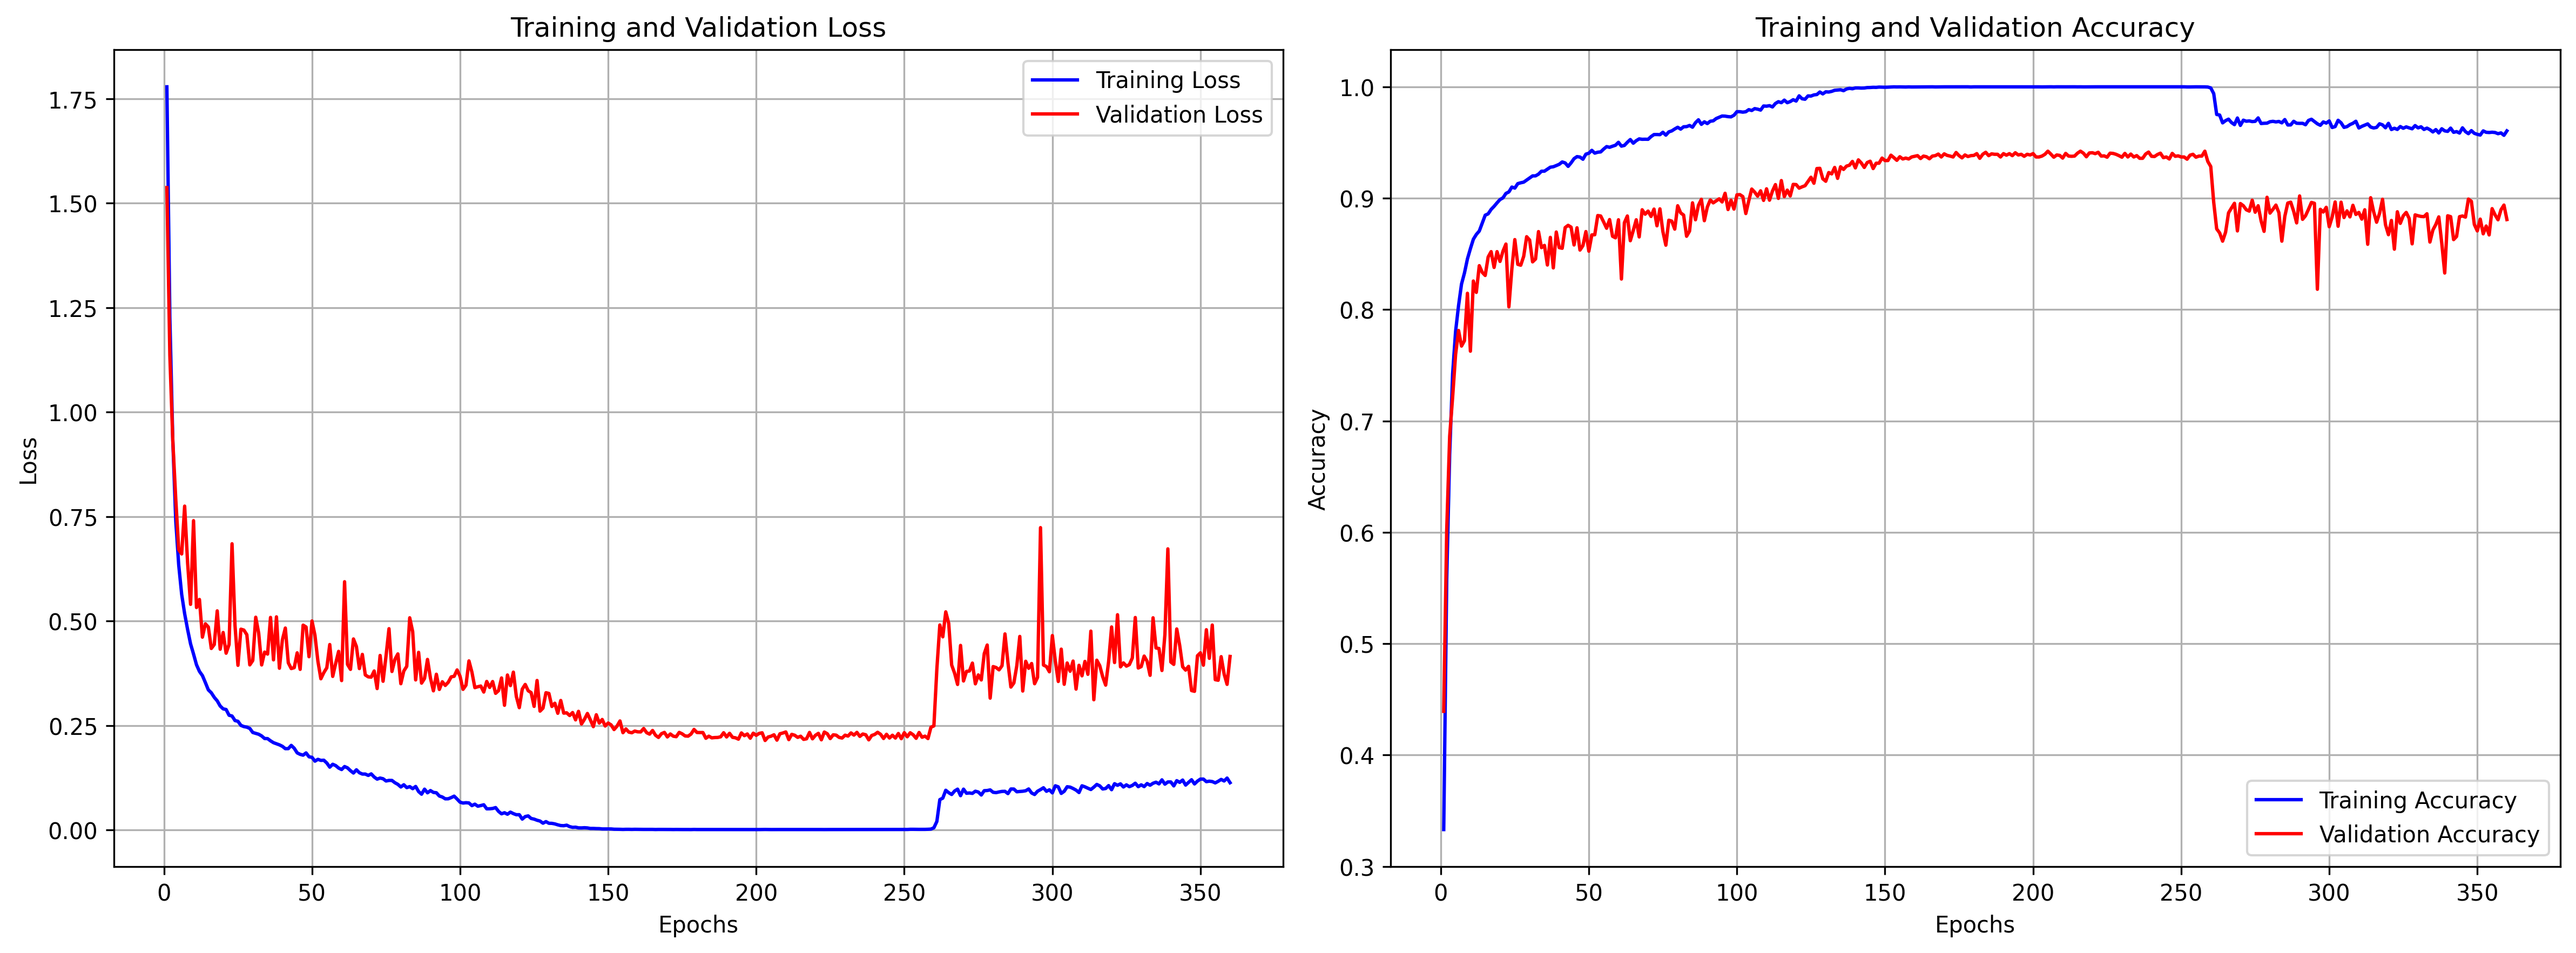

From the above training graphs we can see the model behaviour during the training phase. We observe the rapid initial improvement in both metrics during the first 50 epochs, achieving 80%+ validation accuracy. As training continues, we can see the growing separation between training and validation metrics, with training accuracy approaching 100% while validation plateaus around 90-94%. The sharp transitions at epochs 150 and 250 correspond to our scheduled learning rate reductions, which provide temporary performance boosts. Notably, after epoch 250, validation loss increases while accuracy slightly decreases, indicating diminishing returns from additional training.From this we can conclude in future we should be trying to regularize the model and implement a shorter early stopping in order to prevent overfitting.

After, the training is done we load the best saved model in order to run inference.

In [ ]:
model = load_model(blocks, use_bottleneck=bottleneck, alpha=alpha)

In [ ]:
run_inference(model, test_data)

Using device: cuda
Loading test data...
Running inference...


100%|██████████| 79/79 [00:09<00:00,  8.14it/s]

Creating submission file...
✅ Submission file saved as kaggle_submission.csv


The plot_confusion_matrix function generates a confusion matrix to visualize the model's classification performance. It takes the true labels (y_true), predicted labels (y_pred), and class names as inputs. The function computes the confusion matrix using confusion_matrix(y_true, y_pred) and normalizes it by dividing each row by the total number of samples in that class. It then creates a heatmap using Seaborn, where the x-axis represents predicted labels and the y-axis represents true labels. The heatmap displays both raw counts and normalized values, making it easier to interpret model performance.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

    return cm

The analyze_results function evaluates the model's classification performance by computing key metrics, generating a classification report, and saving the results. It first creates a directory (save_dir) to store the outputs. The function calculates accuracy, precision, recall, and F1-score using accuracy_score, precision_score, recall_score, and f1_score, all computed with a macro average to give equal weight to all classes. The results are printed and also written to a classification report file (classification_report.txt). The function then calls plot_confusion_matrix to visualize the model's predictions, saving the confusion matrix as an image (confusion_matrix.png). Finally, it returns a dictionary containing all computed metrics and the confusion matrix, providing a comprehensive analysis of the model's performance.

In [ ]:
def analyze_results(y_true, y_pred, class_names, save_dir='test_results'):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    os.makedirs(save_dir, exist_ok=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1-Score: {f1:.4f}")

    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    with open(os.path.join(save_dir, 'classification_report.txt'), 'w') as f:
        f.write(f"Overall Accuracy: {accuracy:.4f}\n")
        f.write(f"Macro Precision: {precision:.4f}\n")
        f.write(f"Macro Recall: {recall:.4f}\n")
        f.write(f"Macro F1-Score: {f1:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
    cm = plot_confusion_matrix(
        y_true,
        y_pred,
        class_names,
        save_path=os.path.join(save_dir, 'confusion_matrix.png')
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

The **plot_misclassified_examples** function identifies and visualizes misclassified images from a dataset to analyze model errors. It first sets the model to evaluation mode and iterates through the test data loader without computing gradients. For each batch, it obtains the model's predictions and compares them with the true labels. Any misclassified images are stored along with their true and predicted labels until the specified number (num_examples) is reached. The function then denormalizes the images using the dataset’s mean and standard deviation, ensuring they appear correctly when displayed. A grid of images is created using matplotlib, where each subplot shows a misclassified image along with its true and predicted class labels. If the total number of images is odd, unused subplots are hidden. The final visualization is saved as misclassified_examples.png in the test_results directory and displayed. This function helps in understanding the model’s weaknesses by highlighting common misclassification patterns.

In [ ]:
def plot_misclassified_examples(model, data_loader, device, class_names, num_examples=10, save_dir='test_results'):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            misclassified_idx = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in misclassified_idx:
                misclassified_images.append(images[idx].cpu())
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(preds[idx].item())

                if len(misclassified_images) >= num_examples:
                    break

            if len(misclassified_images) >= num_examples:
                break

    if not misclassified_images:
        print("No misclassified examples found.")
        return

    num_rows = (num_examples + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3*num_rows))

    if num_rows == 1:
        axes = axes.reshape(1, 2)

    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])

    for i, (img, true_label, pred_label) in enumerate(zip(misclassified_images, misclassified_labels, misclassified_preds)):
        if i >= num_examples:
            break

        row, col = i // 2, i % 2

        img = img * std[:, None, None] + mean[:, None, None]
        img = torch.clamp(img, 0, 1)

        axes[row, col].imshow(img.permute(1, 2, 0))
        axes[row, col].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        axes[row, col].axis('off')
    for i in range(len(misclassified_images), num_rows * 2):
        row, col = i // 2, i % 2
        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'misclassified_examples.png'), dpi=300, bbox_inches='tight')
    plt.show()

Now we again declare the variables to, generate test results on the test_batch

In [ ]:
model_path = 'saved_models/best_pyramidnet.pth'
batch_size = 128
num_blocks = [4, 4, 4]
use_bottleneck = True
alpha = 270
save_dir = 'final_test_results'

In [ ]:
os.makedirs(save_dir, exist_ok=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
model = create_pyramidnet(
    num_blocks,
    use_bottleneck=use_bottleneck,
    alpha=alpha,
    num_classes=10
)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


The following snippet prepares the test dataset and data loader to evaluate the trained model on the **CIFAR-10 test set** and generate results. The **test_transform** applies preprocessing steps: converting images to tensors and normalizing pixel values using the CIFAR-10 dataset’s mean and standard deviation, ensuring consistency with the model’s training process. The **test_files** list specifies the test batch file (**test_batch**), which is loaded using the **CIFAR10Dataset** class with the defined transformations. A **DataLoader** is then created to efficiently iterate through test images in batches, ensuring no shuffling since the test set is used for evaluation.

The **class_names** list defines the 10 **CIFAR-10** classes, mapping numerical labels to their corresponding category names. Finally, the print statement indicates that the model evaluation on the test set is about to begin. Once the test batch is loaded, the model will process it to generate predictions, accuracy scores, and other performance metrics.

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_files = ["test_batch"]
test_dataset = CIFAR10Dataset(test_files, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("\nEvaluating model on test set...")


Loaded data shape: (10000, 3, 32, 32)

Evaluating model on test set...


In [ ]:
model.eval()
criterion = nn.CrossEntropyLoss()

correct = 0
total = 0
running_loss = 0.0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
avg_loss = running_loss / len(test_loader)

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({correct}/{total})")



```
Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.85it/s]
Test Loss: 0.2344
Test Accuracy: 0.9420 (9420/10000)
```



In [ ]:
print("\nAnalyzing results...")
metrics = analyze_results(all_labels, all_predictions, class_names, save_dir=save_dir)

print("\nPlotting misclassified examples...")
plot_misclassified_examples(model, test_loader, device, class_names, num_examples=10, save_dir=save_dir)

print(f"\nTest completed successfully. Results saved to '{save_dir}' directory.")



```
Analyzing results...
Overall Accuracy: 0.9420
Macro Precision: 0.9419
Macro Recall: 0.9420
Macro F1-Score: 0.9419

Classification Report:
              precision    recall  f1-score   support

    airplane       0.95      0.96      0.95      1000
  automobile       0.97      0.98      0.97      1000
        bird       0.93      0.93      0.93      1000
         cat       0.88      0.86      0.87      1000
        deer       0.93      0.94      0.94      1000
         dog       0.91      0.91      0.91      1000
        frog       0.95      0.97      0.96      1000
       horse       0.97      0.96      0.96      1000
        ship       0.96      0.96      0.96      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Confusion matrix saved to final_test_results\confusion_matrix.png
```



The above test results show excellent overall performance with our PyramidNet model achieving 94.20% accuracy on the CIFAR-10 test set. The consistency between precision (0.9419), recall (0.9420), and F1-score (0.9419) indicates balanced performance across all classes. Looking at the per-class metrics, the model performs exceptionally well on structured objects like automobiles, horses, ships, and trucks (all with F1-scores of 0.96-0.97). The most challenging class is "cat" with relatively lower precision (0.88) and recall (0.86), suggesting some difficulty distinguishing cat features from other animals, particularly dogs. This pattern is common in CIFAR-10 classification where distinguishing between similar animal classes typically presents the greatest challenge. The saved confusion matrix will provide further insights into specific misclassification patterns between classes. These results validate our model architecture choices and training approach, though there may still be room for improvement with more sophisticated data augmentation targeting the animal classes.

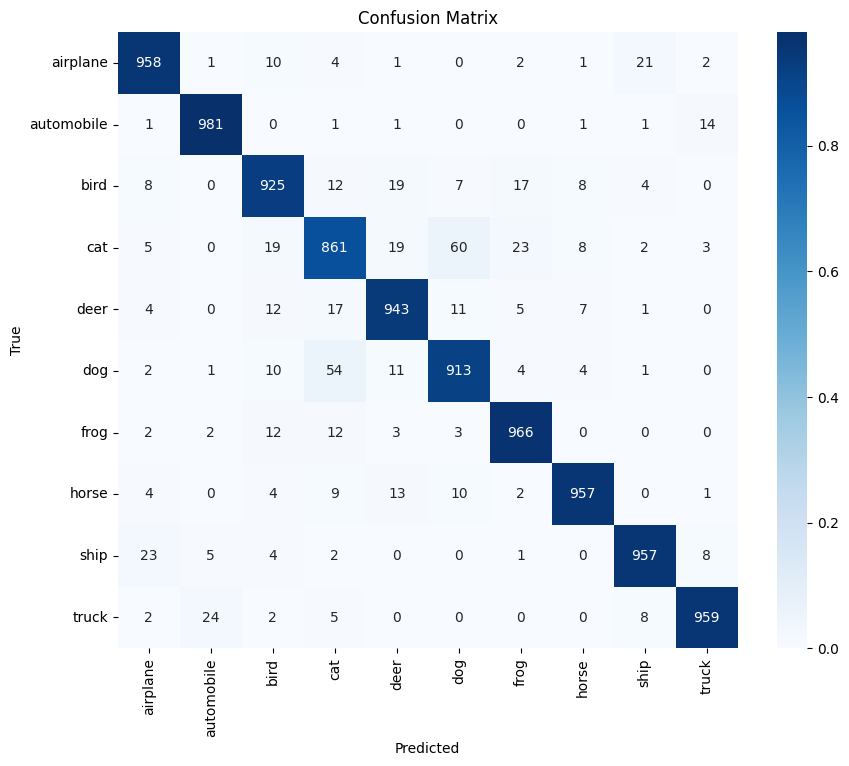

Looking at the confusion matrix, it perfectly aligns with our previous analysis. The matrix confirms that "cat" has the lowest accuracy (861/1000 correct classifications), with significant confusion with "dog" (60 cats predicted as dogs). This validates our observation about challenges distinguishing between similar animal classes. The other notable confusions include:

Ship-airplane confusion (23 ships misclassified as airplanes)
Truck-automobile confusion (24 trucks misclassified as automobiles)
Dog-cat confusion (54 dogs misclassified as cats)

The vehicle classes (automobile, truck, ship) generally show strong performance but have some logical cross-confusion due to similar visual features. Similarly, animal classes show more inter-class confusion, with the cat-dog pair showing the highest mutual misclassification. Frogs perform exceptionally well (966/1000), likely due to their distinctive features and colors that separate them from other classes.
The strong diagonal in the matrix confirms the model's overall excellent performance (94.2% accuracy), with most errors occurring between visually similar categories, as would be expected in a well-trained model.

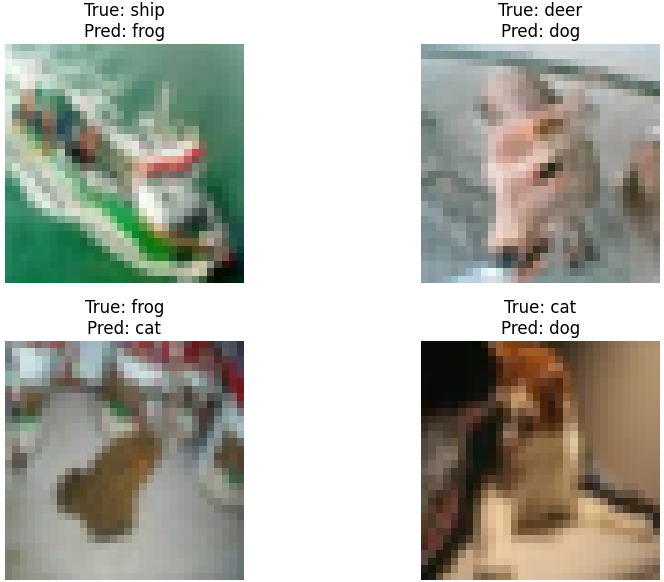

In the above case we can see the examples from **test_batch** where the model has failed to classify the images